In [1]:
from google.colab import files
uploaded = files.upload()

Saving spam.csv to spam.csv


Importing Relevant Libraries

In [1]:
!python -m spacy download en_core_web_lg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 9.5 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [2]:
import pandas as pd
import numpy as np
import gensim
import spacy
nlp = spacy.load('en_core_web_lg')
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [3]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [8]:
stop_words = stopwords.words('english')

In [9]:
import re
import string

Reading Data into python

In [14]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/spam.csv', encoding='ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [15]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [16]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
df.rename({'v1': 'category', 'v2': 'text'}, axis=1, inplace=True)
df.head()

,category,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [17]:
df.text[0]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [18]:
df.category.value_counts()

ham     4825
spam     747
Name: category, dtype: int64

We can approach using three ways.

Using Spacy pre-trained vectors
Using Gensim word2vec and google pre-trained vectors
Using keras embedding layer
1. Using Spacy
Preprocessing

In [19]:
def spacy_process(text):
    filtered = []
    doc = nlp(text)
    for token in doc:
        if token.is_stop or token.is_punct or token.is_space:
            continue
        if token.has_vector:
            filtered.append(token.lemma_)
    return " ".join(filtered)

Using spcay vectors

In [20]:
df['spacy_filtered'] = df['text'].apply(spacy_process)
df.head()

,category,text,spacy_filtered
0,ham,"Go until jurong point, crazy.. Available only ...",point crazy available n great world la e buffe...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 comp win FA Cup final 21st 2005 t...
3,ham,U dun say so early hor... U c already then say...,U dun early hor u c
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think go live


In [21]:
df['spacy_vector'] = df['spacy_filtered'].apply(lambda text: nlp(text).vector)
df['spacy_vector'][0].shape

(300,)

In [22]:
le = LabelEncoder()
y = le.fit_transform(df.category)
np.unique(y, return_counts=True)

(array([0, 1]), array([4825,  747]))

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df.spacy_vector.values, y, 
                                                    test_size=0.2, random_state=42, 
                                                    stratify=y)
X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)
mx_scale = MinMaxScaler()
scaled_fit = mx_scale.fit(X_train_2d)
scaled_train = scaled_fit.transform(X_train_2d)
scaled_test = scaled_fit.transform(X_test_2d)

Modelling using Naive-Bayes

In [24]:
nbc = MultinomialNB()
spacy_nbc_model = nbc.fit(scaled_train, y_train)
spacy_nbc_pred = spacy_nbc_model.predict(scaled_test)
accuracy_score(y_test, spacy_nbc_pred)

0.8645739910313901

In [25]:
confusion_matrix(y_test, spacy_nbc_pred)

array([[962,   4],
       [147,   2]])

We get a reasonably good performance using spacy
2. Gensim Word2Vec
Preprocessing

In [26]:
wordnet_lemmatizer = WordNetLemmatizer()
def to_lower(text):
    return text.lower()
def special_character(text):
    return re.sub('[^\w\s]', ' ', text)
def tokenize_text(text):
    return nltk.word_tokenize(text)
def remove_punct(token_list):
    return [token for token in token_list if token not in string.punctuation]
def remove_stop(token_list):
    return [token for token in token_list if token not in stop_words]
def lemmatize_tokens(token_list):
    return [wordnet_lemmatizer.lemmatize(token) for token in token_list]
def preprocess_text(text):
    text = to_lower(text)
    text = special_character(text)
    text = tokenize_text(text)
    text = remove_punct(text)
    text = remove_stop(text)
    text = lemmatize_tokens(text)
    return text
df['filtered'] = df['text'].apply(preprocess_text)
df.head()

,category,text,spacy_filtered,spacy_vector,filtered
0,ham,"Go until jurong point, crazy.. Available only ...",point crazy available n great world la e buffe...,"[1.2490928, 0.89659774, 0.1631842, -0.6977224,...","[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,"[-0.14939333, 1.0167166, 0.4778967, -1.6510634...","[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 comp win FA Cup final 21st 2005 t...,"[-0.30039942, -3.3519263, 2.5582006, 1.32563, ...","[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,ham,U dun say so early hor... U c already then say...,U dun early hor u c,"[-3.1497614, 2.9741237, 3.1699975, -1.5791801,...","[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think go live,"[0.055519976, 3.9397497, -4.2775974, -0.347967...","[nah, think, go, usf, life, around, though]"


In [27]:
tokens = pd.Series(df.filtered.values)

Continous Bag of Words and Skipgram

In [28]:
cbow_model = gensim.models.Word2Vec(tokens, size=300, min_count=2)
sgram_model = gensim.models.Word2Vec(tokens, size=300, min_count=2, sg=1)
print('cbow model vocabulary size:', len(cbow_model.wv.vocab))

print('skgram model vocabulary size:', len(sgram_model.wv.vocab))

cbow model vocabulary size: 3976
skgram model vocabulary size: 3976


In [29]:
cbow_model.wv.most_similar('great')

[('one', 0.9999732971191406),
 ('amp', 0.9999717473983765),
 ('day', 0.9999714493751526),
 ('thing', 0.9999707341194153),
 ('n', 0.9999700784683228),
 ('love', 0.9999694228172302),
 ('go', 0.999968409538269),
 ('give', 0.9999679923057556),
 ('got', 0.9999678134918213),
 ('see', 0.9999678134918213)]

In [30]:
sgram_model.wv.most_similar('great')

[('wish', 0.9988927841186523),
 ('sweet', 0.9985026717185974),
 ('lot', 0.9980373382568359),
 ('always', 0.997860312461853),
 ('nice', 0.9977997541427612),
 ('many', 0.9977939128875732),
 ('dear', 0.9977502822875977),
 ('keep', 0.9976666569709778),
 ('ya', 0.997391939163208),
 ('fine', 0.9973911046981812)]

Google News Vectors

In [32]:
file_name = '/https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'
google_model = gensim.models.KeyedVectors.load_word2vec_format(file_name, binary=True)

FileNotFoundError: ignored

Word embeddings to Sentence embeddings

In [ ]:
def get_mean_vector(word2vec_model, words):
    # remove out-of-vocabulary words
    words = [word for word in words if word in word2vec_model.wv.vocab]
    if len(words) >= 1:
        return np.mean(word2vec_model.wv[words], axis=0)
    else:
        return np.nan #nan easier to work with
df['cbow_vectors'] = df['filtered'].apply(lambda x: get_mean_vector(cbow_model, x))
df['sgram_vectors'] = df['filtered'].apply(lambda x: get_mean_vector(sgram_model, x))
df['google_vectors'] = df['filtered'].apply(lambda x: get_mean_vector(google_model, x))

In [ ]:
df.head(2)

In [ ]:
df.shape

In [ ]:
df.isnull().sum()

In [ ]:
df[df['cbow_vectors'].isnull() == True]

In [ ]:
df = df.dropna().reset_index(drop=True)
df.head(3)

In [ ]:
df.shape

In [ ]:
X_cbow = pd.DataFrame(df['cbow_vectors'].values.tolist())
X_sgram = pd.DataFrame(df['sgram_vectors'].values.tolist())
X_google = pd.DataFrame(df['google_vectors'].values.tolist())
X_cbow.shape, X_sgram.shape, X_google.shape

In [ ]:
df.category.value_counts()

In [ ]:
label_encode = LabelEncoder()

In [ ]:
y = label_encode.fit_transform(df['category'])
y

In [ ]:
np.unique(y, return_counts=True)

In [ ]:
X_train_cbow, X_test_cbow, y_train_cbow, y_test_cbow = train_test_split(X_cbow, y, 
                                                                        test_size=0.2, 
                                                                        random_state=42, 
                                                                        stratify=y)

In [ ]:
X_train_cbow.shape, X_test_cbow.shape

In [ ]:
y_train_cbow.shape, y_test_cbow.shape

In [ ]:
X_train_sgram, X_test_sgram, y_train_sgram, y_test_sgram = train_test_split(X_sgram, y, 
                                                                            test_size=0.2, 
                                                                            random_state=42, 
                                                                            stratify=y)

In [ ]:

X_train_google, X_test_google, y_train_google, y_test_google = train_test_split(X_google, y, 
                                                                                test_size=0.2, 
                                                                                random_state=42, 
                                                                                stratify=y)

Modelling

In [ ]:

def build_model(model_name, train_data, test_data):
    train_X, train_y = train_data
    test_X, test_y = test_data
    model_fit = model_name.fit(train_X, train_y)
    model_pred = model_fit.predict(test_X)
    print(f'\nAccuracy score is: {accuracy_score(test_y, model_pred)}')
    print(f'\nConfusion matrix: \n{confusion_matrix(test_y, model_pred)}')

CBOW Model

In [ ]:
cbow_pipe = Pipeline([('scale_date', MinMaxScaler()), 
                      ('naive_bayes', MultinomialNB())])
build_model(cbow_pipe, (X_train_cbow, y_train_cbow), (X_test_cbow, y_test_cbow))

In [ ]:
sgram_pipe = Pipeline([('scale_date', MinMaxScaler()), 
                      ('naive_bayes', MultinomialNB())])
build_model(sgram_pipe, (X_train_sgram, y_train_sgram), (X_test_sgram, y_test_sgram))

Skipgram gave good performance as each embedding gets information from adjacent sides.

Google-news Model

In [ ]:
google_pipe = Pipeline([('scale_date', MinMaxScaler()), 
                      ('naive_bayes', MultinomialNB())])

In [ ]:
build_model(google_pipe, (X_train_google, y_train_google), (X_test_google, y_test_google))

since the google news vectors aren't built from the data, the model failed to learn.

3. Using Keras Embedding layer

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, Flatten

In [35]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/spam.csv', encoding='ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [36]:

df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
df.rename({'v1': 'category', 'v2': 'text'}, axis=1, inplace=True)
df.head()

,category,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [37]:
df.groupby('category').describe().T

category                        ham  \
text count                     4825   
     unique                    4516   
     top     Sorry, I'll call later   
     freq                        30   

category                                                  spam  
text count                                                 747  
     unique                                                653  
     top     Please call our customer service representativ...  
     freq                                                    4

In [38]:
df['category_enc'] = df['category'].map({'ham': 0, 'spam': 1})
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['category_enc'], 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=df['category_enc'])
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
train_encoded = tokenizer.texts_to_sequences(X_train)
test_encoded = tokenizer.texts_to_sequences(X_test)
print(train_encoded[0:2])

[[72, 18, 326, 118, 1268], [1, 347, 23, 1269, 665, 5, 422]]


In [39]:
train_len = [len(i) for i in train_encoded]
print(np.median(train_len))
print(np.mean(train_len))
print(np.max(train_len))

12.0
15.757011442674445
189


In [40]:
max_len = 50

In [41]:
train_padded = pad_sequences(train_encoded, maxlen=max_len, padding='post')
test_padded = pad_sequences(test_encoded, maxlen=max_len, padding='post')
test_padded

array([[ 122,  150,   48, ...,    0,    0,    0],
       [   1,   59,    8, ...,    0,    0,    0],
       [  39,   19,   37, ...,    0,    0,    0],
       ...,
       [  37,  549,  700, ...,    0,    0,    0],
       [ 112,    1,  760, ...,    0,    0,    0],
       [ 103,   62, 1100, ...,    0,    0,    0]], dtype=int32)

In [42]:
len(train_encoded[10])

13

In [43]:
len(train_padded[10])

50

In [44]:
vocab_size = len(tokenizer.word_index) + 1

Simple RNN model

In [45]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=300, input_length=max_len))
model.add(SimpleRNN(128, dropout=0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 300)           2375700   
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               54912     
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,447,253
Trainable params: 2,447,253
Non-trainable params: 0
_________________________________________________________________


In [46]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = model.fit(train_padded, 
                    y_train, 
                    epochs=50, 
                    validation_data=[test_padded, y_test], 
                    callbacks=[early_stop], 
                    verbose=2)

Epoch 1/50
140/140 - 13s - loss: 0.3730 - accuracy: 0.8652 - val_loss: 0.3820 - val_accuracy: 0.8664 - 13s/epoch - 93ms/step
Epoch 2/50
140/140 - 8s - loss: 0.3811 - accuracy: 0.8658 - val_loss: 0.3931 - val_accuracy: 0.8664 - 8s/epoch - 59ms/step
Epoch 3/50
140/140 - 8s - loss: 0.3961 - accuracy: 0.8658 - val_loss: 0.4133 - val_accuracy: 0.8664 - 8s/epoch - 60ms/step
Epoch 4/50
140/140 - 8s - loss: 0.4009 - accuracy: 0.8647 - val_loss: 0.3730 - val_accuracy: 0.8673 - 8s/epoch - 61ms/step
Epoch 5/50
140/140 - 8s - loss: 0.3635 - accuracy: 0.8701 - val_loss: 0.3775 - val_accuracy: 0.8646 - 8s/epoch - 58ms/step
Epoch 6/50
140/140 - 9s - loss: 0.3818 - accuracy: 0.8665 - val_loss: 0.3844 - val_accuracy: 0.8601 - 9s/epoch - 67ms/step
Epoch 7/50
140/140 - 8s - loss: 0.3712 - accuracy: 0.8661 - val_loss: 0.3822 - val_accuracy: 0.8610 - 8s/epoch - 61ms/step
Epoch 8/50
140/140 - 8s - loss: 0.3693 - accuracy: 0.8638 - val_loss: 0.3781 - val_accuracy: 0.8664 - 8s/epoch - 58ms/step
Epoch 9/50
140

In [47]:
rnn_data = pd.DataFrame(history.history)
rnn_data.head()

,loss,accuracy,val_loss,val_accuracy
0,0.373033,0.865156,0.381999,0.866368
1,0.381055,0.865829,0.393121,0.866368
2,0.396119,0.865829,0.413308,0.866368
3,0.400944,0.864707,0.373014,0.867265
4,0.363524,0.870092,0.377489,0.864574


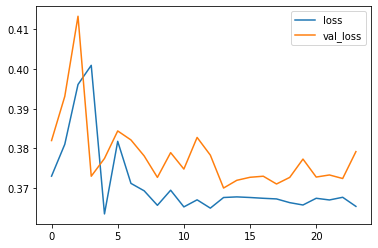

In [48]:
rnn_data[['loss', 'val_loss']].plot()


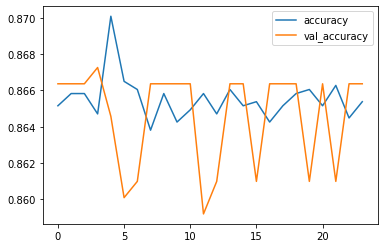

In [49]:
rnn_data[['accuracy', 'val_accuracy']].plot()

In [50]:
from sklearn.metrics import accuracy_score, confusion_matrix
predictions = (model.predict(test_padded) > 0.5).astype('int32')
accuracy_score(y_test, predictions)

35/35 [==============================] - 0s 5ms/step


0.8663677130044843

In [51]:
confusion_matrix(y_test, predictions)

array([[966,   0],
       [149,   0]])

SGRAM Model gave best performance